AutoEncoders with linear activation, one hidden layer and MSE is equivalent to PCA. It learns representation similar to that of PCA. AutoEncoder can project the data into a non-linear manifold. So, it does better than PCA for high dimensional images like PCA. However, they are not genereative models(they dont define distributions like GANS and VAE, which we will see next). Also, there is the problem of what should the latent dimension be. 

$Encoder_{_{\theta}}\left(x^{(i)}\right)=z^{(i)}$ <br>
Decoder $_{\phi}\left(z^{(i)}\right)=\tilde{x}^{(i)}$ <br>
$\operatorname{\ loss}(\theta, \phi)=\sum_{i=1}^{n}\left\|x^{(i)}-\tilde{x}^{(i)}\right\|_{2}^{2}$ i.e $\ loss=\operatorname{MSE}(x, \tilde{x})$

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math

In [ ]:
hyper_param = {"batch_size" : 512,
               "epochs" : 10,
               "learning_rate" : 1e-3}

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root ="./data",train=True,download=True,transform = transform)
train_loader = DataLoader(train_dataset,batch_size=hyper_param["batch_size"],shuffle=True)

test_dataset = datasets.MNIST(root ="./data",train=False,download=True,transform = transform)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [ ]:

def get_OutputSize(inputsize,kernelsize,stride=1,padding=0,dilation=1):
    return math.floor(((inputsize+2*padding-dilation*(kernelsize-1)-1)/stride)+1)

def get_outputSizeT(inputsize,kernelsize,stride=1,padding=0,dilation=1,output_padding=0):
    return (inputsize-1)*stride-2*padding+dilation*(kernelsize-1)+output_padding+1

In [ ]:
class AutoEncoderFullCNN(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder_hidden1 = nn.Conv2d(1,16,3,2,padding=1)
        self.encoder_hidden2 = nn.Conv2d(16,32,3,2,padding=1)
        self.encoder_flatten = nn.Flatten()
        self.encoder_output_layer = nn.Linear(in_features=1568, out_features=10)#compressed vector
        
        #Decoder
        self.decoder_hidden1 = nn.Linear(in_features=10, out_features=1568)
        self.decoder_hidden2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.decoder_hidden3 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.decoder_output_layer = nn.ConvTranspose2d(8, 1, 3, stride=1, padding=1)

    def forward(self, features, encode = True,getEmbd=False):
        
        if encode:
            ##Encoder
            output = torch.relu(self.encoder_hidden1(features))
            output = torch.relu(self.encoder_hidden2(output))
            output = self.encoder_flatten(output)
            compressed = torch.relu(self.encoder_output_layer(output))
            if getEmbd:
              return compressed
            
        else:
            compressed = features.reshape(1,10)
        
        #Decoder
        output = torch.relu(self.decoder_hidden1(compressed))
        output = output.reshape(-1,32,7,7)
        output = torch.relu(self.decoder_hidden2(output))
        output = torch.relu(self.decoder_hidden3(output))
        
        output = self.decoder_output_layer(output)
        reconstructed = torch.sigmoid(output)
        
        return reconstructed, compressed

In [ ]:
class AutoEncoderCNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder_hidden1 = nn.Conv2d(1,16,3,2,padding=1)
        self.encoder_hidden2 = nn.Conv2d(16,32,3,2,padding=1)
        self.encoder_flatten = nn.Flatten()
        self.encoder_output_layer = nn.Linear(in_features=1568, out_features=2)#compressed vector
        
        #Decoder
        self.decoder_hidden1 = nn.Linear(in_features=2, out_features=1568)
        self.decoder_hidden2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.decoder_hidden3 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.decoder_output_layer = nn.ConvTranspose2d(8, 1, 3, stride=1, padding=1)

    def forward(self, features, encode = True,getEmbd=False):
        
        if encode:
            ##Encoder
            output = torch.relu(self.encoder_hidden1(features))
            output = torch.relu(self.encoder_hidden2(output))
            output = self.encoder_flatten(output)
            compressed = torch.relu(self.encoder_output_layer(output))
            if getEmbd:
              return compressed
            
        else:
            compressed = features.reshape(1,2)
        
        #Decoder
        output = torch.relu(self.decoder_hidden1(compressed))
        output = output.reshape(-1,32,7,7)
        output = torch.relu(self.decoder_hidden2(output))
        output = torch.relu(self.decoder_hidden3(output))
        
        output = self.decoder_output_layer(output)
        reconstructed = torch.sigmoid(output)
        
        return reconstructed, compressed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder_model = AutoEncoderCNN2D().to(device)
optimizer = optim.Adam(autoencoder_model.parameters(), lr=hyper_param["learning_rate"],weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,verbose=True)
# mean-squared error loss
criterion = nn.MSELoss()

In [ ]:
for epoch in range(hyper_param["epochs"]):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs,_ = autoencoder_model(batch_features)
        #outputs = autoencoder_model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    #scheduler.step()
    val_loss = 0
    with torch.no_grad():
      for batch_features,_ in test_loader:
        batch_features = batch_features.to(device)
        outputs,_ = autoencoder_model(batch_features)
        #outputs = autoencoder_model(batch_features)
        loss = criterion(outputs, batch_features)
        val_loss += loss.item() 

    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    #path = "gdrive/MyDrive/"+"Model_"+str(epoch) #colab
    path = "Model_Last"#+str(epochs)
    torch.save({
            'epoch': epoch,
            'model_state_dict': autoencoder_model.state_dict(),
            'optimizer_Adam_state_dict': optimizer.state_dict(),
            'train_loss': loss,
            'dev_loss':val_loss,
        }, path)
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f} \t Val recon loss = {:.8f}".format(epoch+ 1, hyper_param["epochs"], loss,val_loss))

epoch : 1/10, recon loss = 0.00018829 	 Val recon loss = 0.02124389
epoch : 2/10, recon loss = 0.00017734 	 Val recon loss = 0.02021619
epoch : 3/10, recon loss = 0.00017548 	 Val recon loss = 0.01970298
epoch : 4/10, recon loss = 0.00019062 	 Val recon loss = 0.01912286
epoch : 5/10, recon loss = 0.00018147 	 Val recon loss = 0.01787765
epoch : 6/10, recon loss = 0.00019097 	 Val recon loss = 0.01756491
epoch : 7/10, recon loss = 0.00018819 	 Val recon loss = 0.01710372
epoch : 8/10, recon loss = 0.00017690 	 Val recon loss = 0.01691741
epoch : 9/10, recon loss = 0.00018971 	 Val recon loss = 0.01678619
epoch : 10/10, recon loss = 0.00017934 	 Val recon loss = 0.01652363


project to 2d

In [ ]:
for epoch in range(hyper_param["epochs"]):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        optimizer.zero_grad()
        outputs,_ = autoencoder_model(batch_features)
        #outputs = autoencoder_model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    #scheduler.step()
    val_loss = 0
    with torch.no_grad():
      for batch_features,_ in test_loader:
        batch_features = batch_features.to(device)
        outputs,_ = autoencoder_model(batch_features)
        #outputs = autoencoder_model(batch_features)
        loss = criterion(outputs, batch_features)
        val_loss += loss.item() 

    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    #path = "gdrive/MyDrive/"+"Model_"+str(epoch) #colab
    path = "Model_Last"#+str(epochs)
    torch.save({
            'epoch': epoch,
            'model_state_dict': autoencoder_model.state_dict(),
            'optimizer_Adam_state_dict': optimizer.state_dict(),
            'train_loss': loss,
            'dev_loss':val_loss,
        }, path)
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f} \t Val recon loss = {:.8f}".format(epoch+ 1, hyper_param["epochs"], loss,val_loss))

epoch : 1/10, recon loss = 0.00156535 	 Val recon loss = 0.11396448
epoch : 2/10, recon loss = 0.00156534 	 Val recon loss = 0.11396020
epoch : 3/10, recon loss = 0.00156534 	 Val recon loss = 0.11395934
epoch : 4/10, recon loss = 0.00156534 	 Val recon loss = 0.11395887
epoch : 5/10, recon loss = 0.00156533 	 Val recon loss = 0.11395719
epoch : 6/10, recon loss = 0.00093377 	 Val recon loss = 0.07446205
epoch : 7/10, recon loss = 0.00068995 	 Val recon loss = 0.06168143
epoch : 8/10, recon loss = 0.00066245 	 Val recon loss = 0.05858621
epoch : 9/10, recon loss = 0.00066157 	 Val recon loss = 0.05583276
epoch : 10/10, recon loss = 0.00064385 	 Val recon loss = 0.05433896


In [ ]:

#Storing representations
done = []
representation = {}
original_images = {}
with torch.no_grad():
    for image, label in test_loader:
        #Just to randomly pick samples to show
        if random.randint(0,10) == 4:
            if label.item() not in done:
                done.append(label.item())
                original_images[done[-1]] = image.numpy().reshape(28,28)
                reconstruction, code = autoencoder_model(image.cuda())
                representation[done[-1]] = code 

            if len(done) == 10:
                break
                

#Reconstructing from latent vector
images = {}
with torch.no_grad():
    for i in range(10):
        reconstruction,_ = autoencoder_model.forward(representation[i], encode=False)
        images[i] = reconstruction.cpu().numpy().reshape(28, 28)

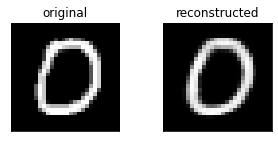

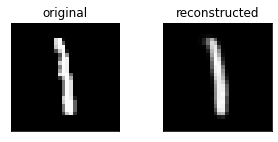

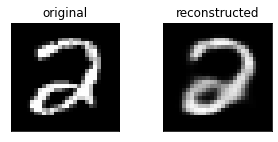

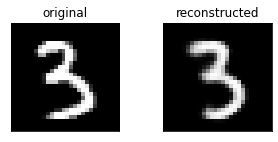

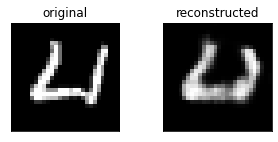

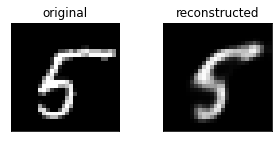

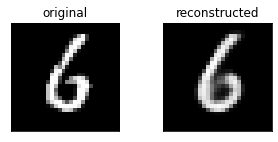

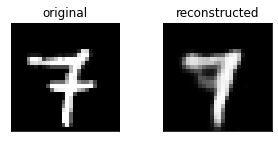

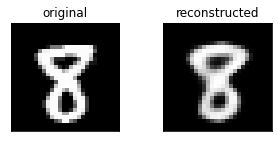

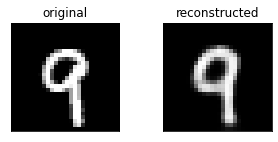

In [ ]:
#Plotting the figures
for i in range(10):
    plt.figure(figsize=(5, 2))
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(original_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('original')
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('reconstructed')

In [ ]:
checkpoint = torch.load("Model_Last")
autoencoder_model.load_state_dict(checkpoint["model_state_dict"])
autoencoder_model.to(device)

AutoEncoderCNN2D(
  (encoder_hidden1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_hidden2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_output_layer): Linear(in_features=1568, out_features=2, bias=True)
  (decoder_hidden1): Linear(in_features=2, out_features=1568, bias=True)
  (decoder_hidden2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_hidden3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_output_layer): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
mnist_list = list(test_dataset)

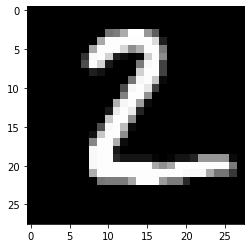

In [ ]:
plt.imshow(mnist_list[1][0].numpy().reshape(28,28),cmap="gray")

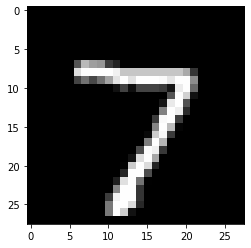

In [ ]:
plt.imshow(mnist_list[0][0].numpy().reshape(28,28),cmap="gray")

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder_model.forward(z,encode=False)[0]
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

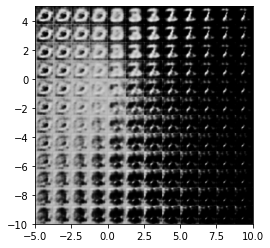

In [ ]:
plot_reconstructed(autoencoder_model)

In [ ]:
from PIL import Image
def interpolate(index1, index2):
    x1 = mnist_list[index1][0].to(device)
    x2 = mnist_list[index2][0].to(device)
    x = torch.stack([x1,x2])
    embedding = autoencoder_model.forward(x,getEmbd = True)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image
    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    #embedding_values = torch.stack(embedding_values)
    recons = [autoencoder_model.forward(x,encode=False)[0].to('cpu').detach().numpy()*255 for x in embedding_values]
    #interpolate_list = recons.to('cpu').detach().numpy()*255
    #recons,_ = autoencoder_model.forward(embedding_values,encode=False)

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in recons]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{"recons"}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

interpolate(0, 1)

**Interpolation Gif**

In [1]:
from IPython.display import Image
Image(filename="recons.gif.png")

FileNotFoundError: [Errno 2] No such file or directory: 'recons.gif.png'